# Variational Autoencoder

In [1]:
import logging

import pandas as pd

import vaep
import vaep.model
import vaep.models as models
from vaep.io import datasplits

import vaep.nb
logger = vaep.logging.setup_logger(logging.getLogger('vaep'))
logger.info("Median Imputation")

figures = {}  # collection of ax or figures

vaep - INFO     Median Imputation


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
folder_experiment: str = 'runs/example'  # Datasplit folder with data for experiment
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'  # Metadata for samples
# model
sample_idx_position: int = 0  # position of index which is sample ID
model_key: str = 'Median'  # model key (lower cased version will be used for file names)
model: str = 'Median'  # model name
save_pred_real_na: bool = True  # Save all predictions for real na
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
file_format = "csv"
fn_rawfile_metadata = "data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv"
folder_experiment = "runs/example"
model_key = "Median"


Some argument transformations

In [5]:
args = vaep.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/example',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'sample_idx_position': 0,
 'model_key': 'Median',
 'model': 'Median',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = vaep.nb.args_from_dict(args)
args

{'data': Path('runs/example/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_experiment': Path('runs/example'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(args.data, file_format=args.file_format)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/example/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/example/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/example/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID                                       Gene Names
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070  KDM1A        28.982
                                                EXOSC7       28.969
2020_01_06_20_17_Q-Exactive-HF-X-Orbitrap_6070  PRKAA1       27.415
2020_02_12_05_06_Q-Exactive-HF-X-Orbitrap_6070  PSMD14       30.981
2020_01_15_13_56_Q-Exactive-HF-X-Orbitrap_6070  PIGS         26.564
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError("More than one feature: Needs to be implemented. see above logging output.")

vaep - INFO     sample_id = 'Sample ID', single feature: index_column = 'Gene Names'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,Version,Content Creation Date,Thermo Scientific instrument model,instrument attribute,instrument serial number,Software Version,firmware version,Number of MS1 spectra,Number of MS2 spectra,MS min charge,...,injection volume setting,Row,dilution factor,electron transfer dissociation,Comment,collision-induced dissociation,sample name,sample volume,Type,Number of MS3 spectra
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-18 14:35:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,336.000","114,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-19 19:48:33,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,312.000","117,156.000",2,...,2.500,2.000,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-20 14:15:00,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,263.000","118,074.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-27 12:29:44,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,862.000","115,333.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,QC,NaN
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 15:06:50,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,776.000","127,143.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019_12_29_18_18_Q-Exactive-HF-X-Orbitrap_6070,66,2019-12-29 18:18:31,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"10,957.000","129,268.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_02_17_38_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-02 17:38:26,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"12,243.000","120,125.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_11_17_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 11:17:32,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"13,189.000","118,093.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020_01_03_16_58_Q-Exactive-HF-X-Orbitrap_6070,66,2020-01-03 16:58:20,Q Exactive HF-X Orbitrap,Q Exactive HF-X Orbitrap,Exactive Series slot #6070,2.9-290204ph16/2.9.0.2926,rev. 1,"11,172.000","126,830.000",2,...,2.500,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initialize Comparison

- replicates idea for truely missing values: Define truth as by using n=3 replicates to impute
  each sample
- real test data:
    - Not used for predictions or early stopping.
    - [x] add some additional NAs based on distribution of data

In [12]:
freq_feat = vaep.io.datasplits.load_freq(args.data)
freq_feat.head()  # training data

Gene Names
AAR2     45
ABCB6    35
ABHD11   30
ACAD9    50
ACTL6A   49
Name: freq, dtype: int64

### Produce some addional fake samples

The validation fake NA is used to by all models to evaluate training performance.

In [13]:
val_pred_fake_na = data.val_y.to_frame(name='observed')
val_pred_fake_na

,,observed
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470


In [14]:
test_pred_fake_na = data.test_y.to_frame(name='observed')
test_pred_fake_na.describe()

,observed
count,859.000
mean,28.270
std,2.543
min,22.254
25%,26.477
50%,28.068
75%,30.064
max,35.919


## Data in wide format

- Autoencoder need data in wide format

In [15]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

Gene Names,AAR2,ABCB6,ABHD11,ACAD9,ACTL6A,ACTN1,ACTR3,ADAM10,AHSA1,AK3,...,WBSCR16,WDR18,WDR33,WDR36,WDR61,WNK1,YBX1,YTHDF1,YWHAH,ZNF326
Sample ID,,,,,,,,,,,,,,,,,,,,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,27.248,24.472,25.714,28.542,29.335,30.837,29.713,26.702,31.696,26.337,...,26.360,28.258,25.507,30.009,28.345,27.701,32.374,24.925,29.609,28.756
2019_12_19_19_48_Q-Exactive-HF-X-Orbitrap_6070,27.211,23.775,NaN,28.437,29.692,30.635,30.340,25.929,31.296,25.415,...,NaN,NaN,23.620,29.348,28.728,NaN,NaN,NaN,29.027,28.393
2019_12_20_14_15_Q-Exactive-HF-X-Orbitrap_6070,27.377,26.852,26.046,28.907,30.369,31.252,30.715,26.403,NaN,25.554,...,27.147,28.335,NaN,30.563,28.859,28.405,32.328,25.498,30.170,29.208
2019_12_27_12_29_Q-Exactive-HF-X-Orbitrap_6070,NaN,24.047,24.788,27.894,29.359,29.996,29.686,NaN,30.882,22.498,...,NaN,28.228,NaN,29.497,27.716,27.349,31.794,24.701,29.232,28.139
2019_12_29_15_06_Q-Exactive-HF-X-Orbitrap_6070,26.520,NaN,NaN,NaN,30.164,33.143,30.985,25.824,31.145,29.210,...,NaN,NaN,26.818,29.374,29.407,28.900,32.443,NaN,30.615,29.189


### Add interpolation performance

In [16]:
# interpolated = vaep.pandas.interpolate(wide_df = data.train_X)
# val_pred_fake_na['interpolated'] = interpolated
# test_pred_fake_na['interpolated'] = interpolated
# del interpolated
# test_pred_fake_na

In [17]:
# Add median pred performance
args.n_params = data.train_X.shape[-1]
medians_train = data.train_X.median()
medians_train.name = args.model
pred = medians_train

val_pred_fake_na = val_pred_fake_na.join(medians_train)
test_pred_fake_na = test_pred_fake_na.join(medians_train)
val_pred_fake_na

,,observed,Median
Sample ID,Gene Names,,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,30.946,30.547
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,27.248,26.880
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,29.310,26.528
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,24.352,27.521
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,29.250,26.839
...,...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,24.294,25.077
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,28.471,27.816
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,29.470,28.381


In [18]:
if args.save_pred_real_na:
    mask = data.train_X.isna().stack()
    idx_real_na = mask.index[mask]
    idx_real_na = (idx_real_na
                   .drop(val_pred_fake_na.index)
                   .drop(test_pred_fake_na.index))
    # hacky, but works:
    pred_real_na = (pd.Series(0, index=idx_real_na, name='placeholder')
                    .to_frame()
                    .join(medians_train)
                    .drop('placeholder', axis=1))
    # pred_real_na.name = 'intensity'
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Median
Sample ID                                      Gene Names         
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070 ARMCX3       25.174
                                               BDH2         25.444
                                               CCBL2        26.548
                                               COMMD5       25.026
                                               DNAJC10      26.456
...                                                            ...
2020_06_02_09_41_Q-Exactive-HF-X-Orbitrap_6070 TMEM261      25.780
                                               TRMT2A       25.232
                                               TSNAX;DISC1  26.891
                                               UTRN         26.371
                                               VPS11        25.126

[1616 rows x 1 columns]

### Plots


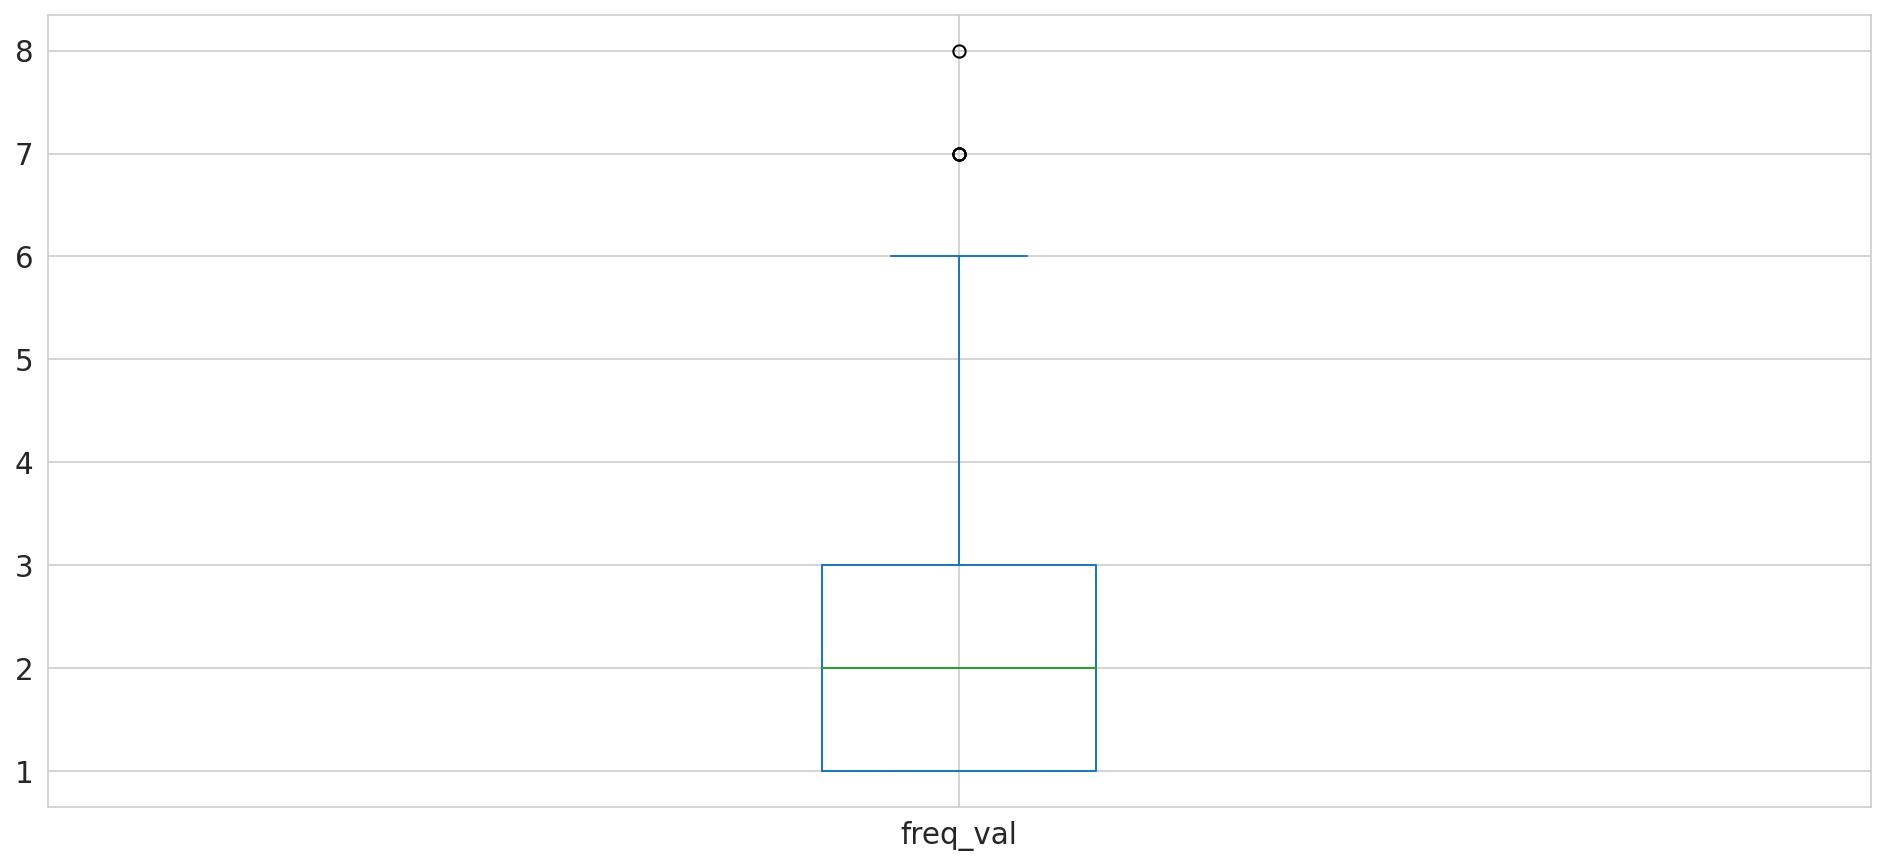

In [19]:
feat_freq_val = val_pred_fake_na['observed'].groupby(level=-1).count()
feat_freq_val.name = 'freq_val'
ax = feat_freq_val.plot.box()

In [20]:
# # scatter plot between overall feature freq and split freq
# freq_feat.to_frame('overall').join(feat_freq_val).plot.scatter(x='overall', y='freq_val')

In [21]:
feat_freq_val.value_counts().sort_index().head()  # require more than one feat?

1   101
2    85
3    89
4    41
5    16
Name: freq_val, dtype: int64

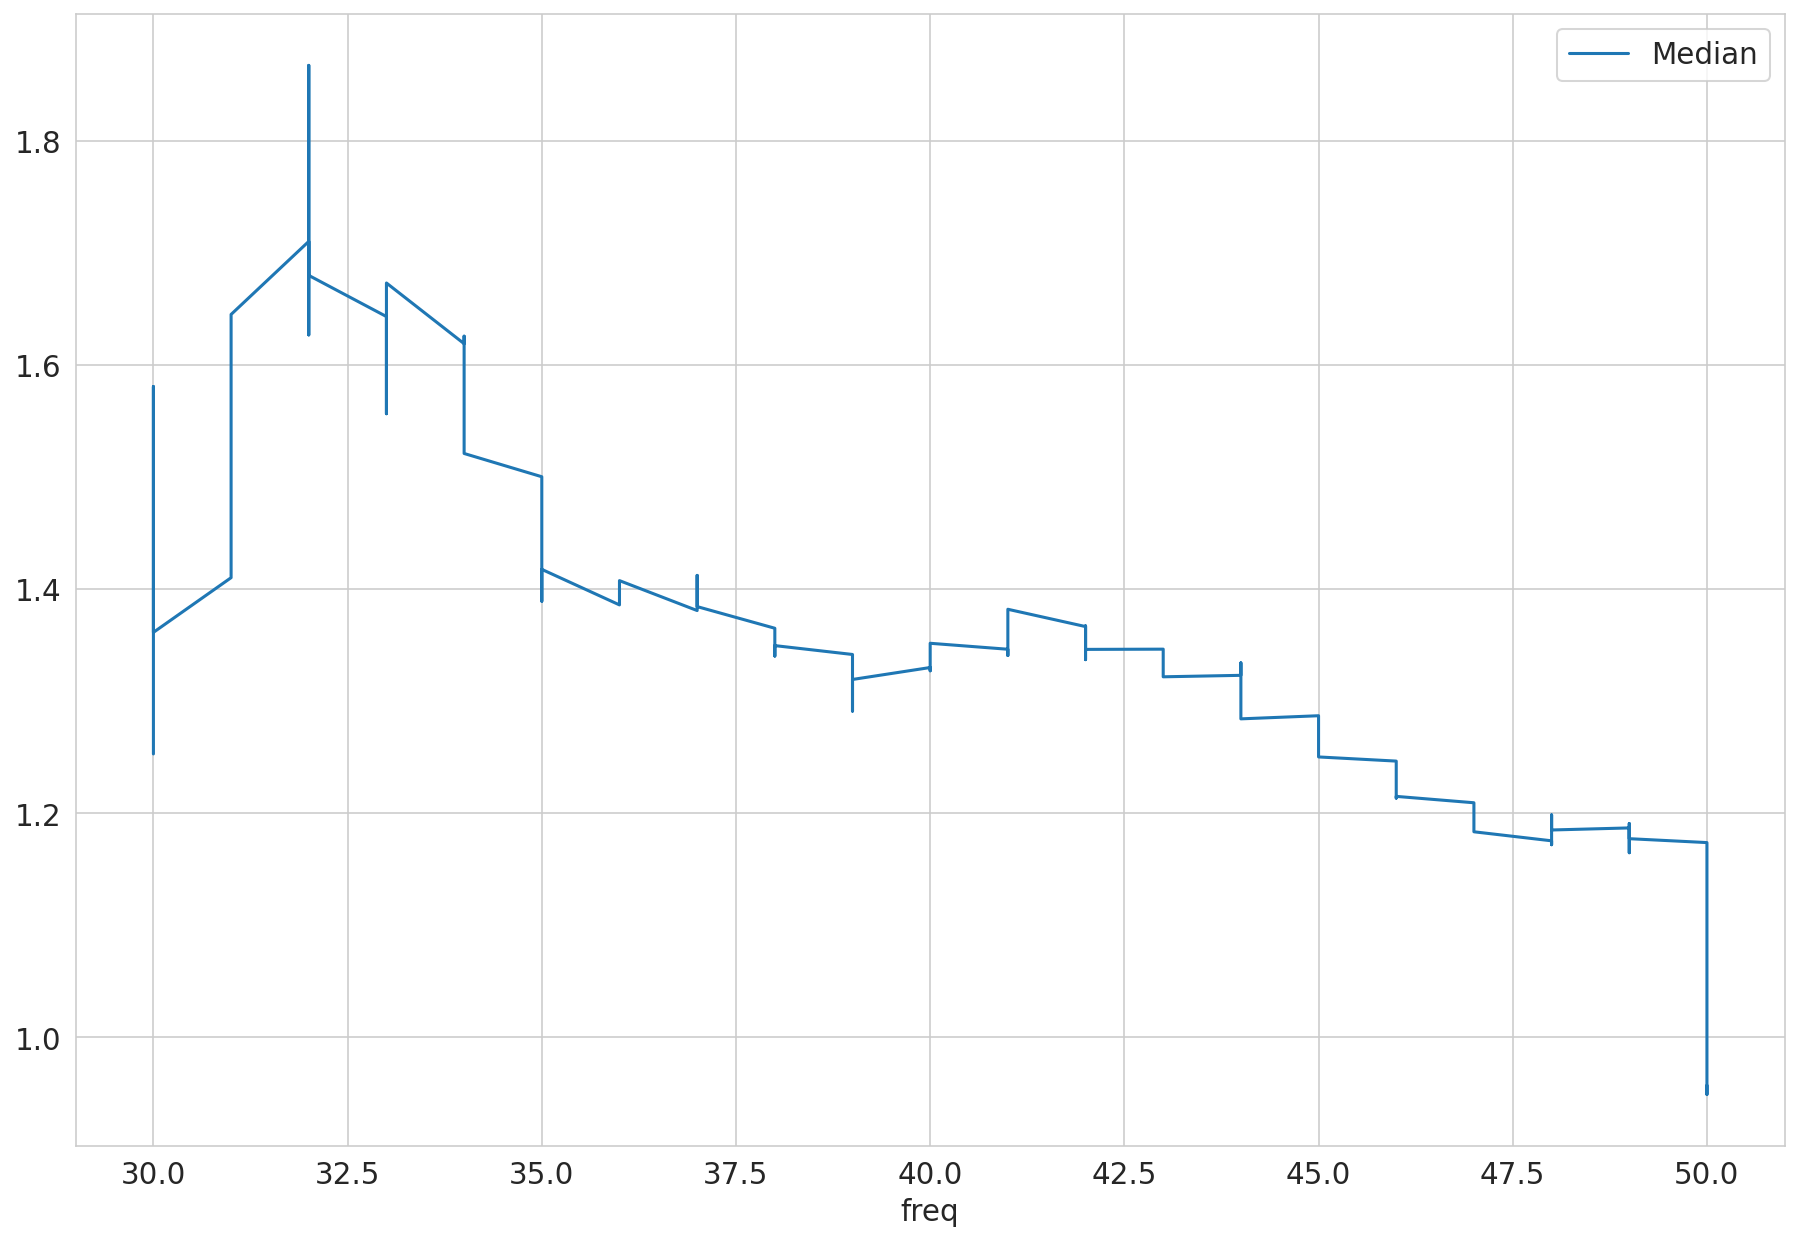

In [22]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val = errors_val.abs().groupby(level=-1).mean()
errors_val = errors_val.join(freq_feat).sort_values(by='freq', ascending=True)


errors_val_smoothed = errors_val.copy()  # .loc[feat_freq_val > 1]
errors_val_smoothed[errors_val.columns[:-
                                       1]] = errors_val[errors_val.columns[:-
                                                                           1]].rolling(window=200, min_periods=1).mean()
ax = errors_val_smoothed.plot(x='freq', figsize=(15, 10))
# errors_val_smoothed

In [23]:
errors_val = val_pred_fake_na.drop('observed', axis=1).sub(val_pred_fake_na['observed'], axis=0)
errors_val.abs().groupby(level=-1).agg(['mean', 'count'])

Median      
             mean count
Gene Names             
AAR2        1.085     2
ABCB6       3.198     3
ABHD11      1.532     4
ACAD9       0.505     2
ACTL6A      1.575     2
...           ...   ...
WNK1        0.799     3
YBX1        0.490     3
YTHDF1      1.413     2
YWHAH       0.763     1
ZNF326      1.518     3

[344 rows x 2 columns]

In [24]:
errors_val

,,Median
Sample ID,Gene Names,
2019_12_18_14_35_Q-Exactive-HF-X-Orbitrap_6070,GEMIN5,-0.399
2020_02_28_12_27_Q-Exactive-HF-X-Orbitrap_6070,AAR2,-0.368
2020_02_13_03_11_Q-Exactive-HF-X-Orbitrap_6070,ADAM10,-2.782
2020_01_04_14_59_Q-Exactive-HF-X-Orbitrap_6070,NDUFAF4,3.169
2020_05_27_13_57_Q-Exactive-HF-X-Orbitrap_6070,EPN1,-2.412
...,...,...
2020_03_01_23_00_Q-Exactive-HF-X-Orbitrap_6070,PRRC2B,0.784
2020_01_04_04_23_Q-Exactive-HF-X-Orbitrap_6070,ARGLU1,-0.655
2020_02_18_18_55_Q-Exactive-HF-X-Orbitrap_6070,GBF1,-1.089


## Comparisons

> Note: The interpolated values have less predictions for comparisons than the ones based on models (CF, DAE, VAE)
> The comparison is therefore not 100% fair as the interpolated samples will have more common ones (especailly the sparser the data)
> Could be changed.

### Validation data

- all measured (identified, observed) peptides in validation data

> Does not make too much sense to compare collab and AEs,
> as the setup differs of training and validation data differs

In [25]:
# papermill_description=metrics
d_metrics = models.Metrics()

The fake NA for the validation step are real test data (not used for training nor early stopping)

In [26]:
added_metrics = d_metrics.add_metrics(val_pred_fake_na, 'valid_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 1.7661151011664733,
  'MAE': 1.0281242373207287,
  'N': 859,
  'prop': 1.0}}

### Test Datasplit

Fake NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

In [27]:
added_metrics = d_metrics.add_metrics(test_pred_fake_na, 'test_fake_na')
added_metrics

Selected as truth to compare to: observed


{'Median': {'MSE': 1.7599435679408746,
  'MAE': 1.0399287235791117,
  'N': 859,
  'prop': 1.0}}

The fake NA for the validation step are real test data (not used for training nor early stopping)

### Save all metrics as json

In [28]:
vaep.io.dump_json(d_metrics.metrics, args.out_metrics / f'metrics_{args.model_key}.json')
d_metrics

{ 'test_fake_na': { 'Median': { 'MAE': 1.0399287235791117,
                                'MSE': 1.7599435679408746,
                                'N': 859,
                                'prop': 1.0}},
  'valid_fake_na': { 'Median': { 'MAE': 1.0281242373207287,
                                 'MSE': 1.7661151011664733,
                                 'N': 859,
                                 'prop': 1.0}}}

In [29]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics, column_levels=['model', 'metric_name']).T
metrics_df

subset              valid_fake_na  test_fake_na
model  metric_name                             
Median MSE                  1.766         1.760
       MAE                  1.028         1.040
       N                  859.000       859.000
       prop                 1.000         1.000

## Save predictions

In [30]:
# val
fname = args.out_preds / f"pred_val_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())  # add [] assignment?
val_pred_fake_na.to_csv(fname)
# test
fname = args.out_preds / f"pred_test_{args.model_key}.csv"
setattr(args, fname.stem, fname.as_posix())
test_pred_fake_na.to_csv(fname)

## Config

In [31]:
figures  # switch to fnames?

{}

In [32]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 376,
 'data': Path('runs/example/data'),
 'file_format': 'csv',
 'fn_rawfile_metadata': 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv',
 'folder_experiment': Path('runs/example'),
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'Median',
 'model_key': 'Median',
 'n_params': 376,
 'out_figures': Path('runs/example/figures'),
 'out_folder': Path('runs/example'),
 'out_metrics': Path('runs/example'),
 'out_models': Path('runs/example'),
 'out_preds': Path('runs/example/preds'),
 'pred_test_Median': 'runs/example/preds/pred_test_Median.csv',
 'pred_val_Median': 'runs/example/preds/pred_val_Median.csv',
 'sample_idx_position': 0,
 'save_pred_real_na': True}